***Vorlesung 'Syntax natürlicher Sprachen', WS 2018/19***

---
# Übung 11

In [1]:
import nltk
from exercises_11 import *
from questions import aufgabe

---
## Aufgabe 1: Herunterladen von Ressourcen

#### Laden Sie sich zunächst die Ressource `corpora/treebank` über den NLTK Download-Manager herunter.

In [2]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

---
## Aufgabe 2: Von Daten zu Regelwahrscheinlichkeiten

#### Gegeben sei folgende kontextfreie Grammatik:

In [3]:
cfg = """
S -> NP VP
VP -> V NP PP
VP -> V NP
NP -> DET N
NP -> NP PP
PP -> P NP

DET -> "the" | "a"
N -> "boy" | "woman" | "telescope"
V -> "saw"
P -> "with"
"""

#### Sie modelliert sehr einfache Sätze der Form `SBJ` *saw* `OBJ` mit optionaler Präpositionalphrase am Ende. Diese Präpositionalphrase kann entweder der näheren Bestimmung des Objekts oder der näheren Bestimmung der in der Verbalphrase ausgedrückten Handlung dienen.

#### Im folgenden sollen aus der Penn Treebank Wahrscheinlichkeiten für die einzelnen Regeln extrahiert werden, um dieser Ambiguität Herr zu werden.

---
### Aufgabe 2a: Relevante Konstruktionen erkennen

#### Nutzen das im NLTK enthaltene Sample der Penn Treebank (nach Installation unter `nltk.corpus.treebank` zu finden) zunächst zur Identifikation der für eine Disambiguierung nützlichen (Teil-)bäume der Penn Treebank.

#### *Hinweis:* Sie können sich bei der Analyse auf die jeweils 30 häufigsten Konstruktionen der Baumbank beschränken.

In [4]:
from collections import defaultdict
from nltk.corpus import treebank

def find_relevant_constructions(lhs, only_with=None):
    lhs_nt = nltk.grammar.Nonterminal(lhs)
    should_filter = only_with is not None
    if should_filter:
        filter_by = list(map(nltk.grammar.Nonterminal, only_with))
        def passes_filter(tup):
            for f in filter_by:
                if f not in tup:
                    return False
            return True

    counter = defaultdict(int)
    ### TODO: zähle Produktionen in treebank mit lhs als linker Seite ###
    ### und einer rechten Seite, für die passes_filter True liefert ###

    return [ (k, counter[k]) for k in sorted(counter.keys(), key=counter.__getitem__) ]

#### Die folgende Code-Zelle sollte mehrmals mit unterschiedlichen Parametern für `find_relevant_constructions` ausgeführt werden. Verschaffen Sie sich so interaktiv die nötigen Informationen zur Lösung der Aufgabe!

In [5]:
constructions = find_relevant_constructions('VP', only_with=["NP"])
constructions[-30:]

[]

---
### Aufgabe 2b:

#### Zählen Sie nun, wie oft die jeweiligen Konstruktionen in der Penn Treebank vorkommen und berechnen Sie die relativen Häufigkeiten als Approximation der Regelwahrscheinlichkeiten. Das Vorgehen wird in folgender Formel veranschaulicht:

$$P(V, N\!P, P\!P \mid V\!P) = \dfrac{count(V\!P \rightarrow V\:N\!P\:P\!P)}{count(V\!P \rightarrow \setminus*)}$$

In [6]:
vp_with_pp_frq = 1
vp_without_frq = 1
vp_with_pp = vp_with_pp_frq / (vp_with_pp_frq + vp_without_frq)
vp_without = vp_without_frq / (vp_with_pp_frq + vp_without_frq)

np_with_pp_frq = 1
np_without_frq = 1
np_with_pp = np_with_pp_frq / (np_with_pp_frq + np_without_frq)
np_without = np_without_frq / (np_with_pp_frq + np_without_frq)

det_the_frq = 1
det_a_frq = 1
det_the = det_the_frq / (det_the_frq + det_a_frq)
det_a = det_a_frq / (det_the_frq + det_a_frq)

(vp_with_pp, vp_without, np_with_pp, np_without, det_the, det_a)

(0.5, 0.5, 0.5, 0.5, 0.5, 0.5)

---
### Aufgabe 2c: Erstellen einer PCFG

#### Die aus den Daten extrahierten relativen Häufigkeiten sollen nun zur Erstellung einer probabilistischen kontextfreien Grammatik (PCFG)  genutzt werden.

In [7]:
pcfg = """
S -> NP VP     [1.0]
VP -> V NP PP  [{}]
VP -> V NP     [{}]
NP -> DET N    [{}]
NP -> NP PP    [{}]
PP -> P NP     [1.0]

DET -> "the"     [{}]
DET -> "a"       [{}]
N -> "boy"       [0.4]
N -> "woman"     [0.4]
N -> "telescope" [0.2]
V -> "saw"       [1.0]
P -> "with"      [1.0]
""".format(
    vp_with_pp, vp_without, np_without,
    np_with_pp, det_the, det_a
)
grammar = nltk.PCFG.fromstring(pcfg)
print(grammar)

Grammar with 13 productions (start state = S)
    S -> NP VP [1.0]
    VP -> V NP PP [0.5]
    VP -> V NP [0.5]
    NP -> DET N [0.5]
    NP -> NP PP [0.5]
    PP -> P NP [1.0]
    DET -> 'the' [0.5]
    DET -> 'a' [0.5]
    N -> 'boy' [0.4]
    N -> 'woman' [0.4]
    N -> 'telescope' [0.2]
    V -> 'saw' [1.0]
    P -> 'with' [1.0]


---
### Aufgabe 2d:

#### Testen Sie Ihre so erstellte Grammatik nun, indem Sie folgenden Satz parsen:

- *the boy saw a woman with a telescope*

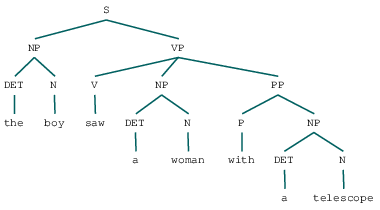

In [8]:
from IPython.display import display

parser = nltk.ViterbiParser(grammar)
for tree in parser.parse("the boy saw a woman with a telescope".split()):
    display(tree)

#### Wenn Sie sich die extrahierten Wahrscheinlichkeiten und das disambiguierte Ergebnis ansehen, überrascht Sie dann das Ergebnis der Syntaxanalyse?

---
## Aufgabe 3: Weiterverarbeitung syntaktischer Analysen

#### In dieser Aufgabe sollen Sie die Ausgaben eines state-of-the-art-Parsers, nämlich des Stanford Parsers, weiterverarbeiten.

#### Mit dem Ziel, Sie erst einmal mit den typischen Strukturen einer solchen Aufgabe vertraut zu machen, sollen Sie in dieser Aufgabe lediglich entscheiden, ob die Eingabe einen Infinitivsatz mit Objekt enthält.

#### Zur Klarheit betrachten Sie die folgenden positiven und negativen Beispiele:

In [9]:
pos_examples = [
    "Er beabsichtigt , den Kuchen ganz alleine zu essen .",
    "Er behauptet , ihn gesehen zu haben ."
]
neg_examples = [
    "Er glaubt , nach Hause zu fliegen .",
    "Zu fliegen ist schön .",
    "Er will gehen ."
]

#### Zur Erinnerung die wichtigsten Schritte zur Nutzung des Stanford Parsers im NLTK:

    1. Initialisierung

#### (Beachten Sie, dass der Pfad-Separator OS-spezifisch ist. `os.path.join` setzt den für das Betriebssystem jeweils richtigen Separator zwischen die Argumente.)

In [10]:
from nltk.parse.stanford import StanfordParser
import os

PATH_TO_CORE = os.path.join(os.getenv("HOME"), "nltk_data", "stanford-corenlp-full-2018-10-05")
PATH_TO_GERMAN_MODEL = os.path.join(os.getenv("HOME"), "nltk_data", "stanford-models-2018-10-05")

jar = os.path.join(PATH_TO_CORE, "stanford-corenlp-3.9.2.jar")
model = os.path.join(PATH_TO_GERMAN_MODEL, "stanford-german-corenlp-2018-10-05-models.jar")

    2. Parser-Erstellung

In [11]:
import warnings
warnings.filterwarnings("ignore")

In [12]:
parser = StanfordParser(
    jar, model,
    model_path="edu/stanford/nlp/models/lexparser/germanPCFG.ser.gz"
)

    3. Parsen

In [13]:
for sentence in pos_examples + neg_examples:
    tree_list = list(parser.raw_parse(sentence))
    tree_list[0].pretty_print(unicodelines=True)

                               ROOT                                      
                                │                                         
                                S                                        
 ┌────────┬────────┬────────────┴─────┬────────────────────────────────┐  
 │        │        │                  VP                               │ 
 │        │        │       ┌──────────┴────┬─────────────────┐         │  
 │        │        │       NP             AVP                VZ        │ 
 │        │        │   ┌───┴────┐     ┌────┴─────┐      ┌────┴────┐    │  
PPER    VVFIN      $, ART       NN   ADV        ADV   PTKZU     VVINF  $.
 │        │        │   │        │     │          │      │         │    │  
 Er  beabsichtigt  ,  den     Kuchen ganz     alleine   zu      essen  . 

                   ROOT                                    
                    │                                       
                    S                                      

#### Betrachten Sie die Ausgabe für die Beispielsätze. Schreiben Sie dann eine Funktion, die `True` zurückgibt, wenn ein Satz mit einem Infinitv, der ein Objekt hat, vorliegt und `False` sonst.

In [14]:
def classify(sentence):
    return False

Die Ausgabe sollte sein:

`True
True
False
False
False`

In [15]:
for p in pos_examples:
    print(classify(p))
for n in neg_examples:
    print(classify(n))

False
False
False
False
False


---
# Hausaufgaben

---
## Aufgabe 4: PCFGs und Viterbi

#### Beantworten Sie die folgenden grundlegenden Fragen über die heute verwendeten Technologien.

In [16]:
aufgabe(blatt11_4)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Welche der folgenden Bedingungen wird an eine…

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Was ist die Aufgabe des Viterbi-Algorithmus?<…

---
## Aufgabe 5: Fragen zu NLTK-08-extras, 2.9 ("Viterbi-Parser")

#### 1. Betrachten Sie die folgende im Kapitel gegebene PCFG:

```
grammar = nltk.PCFG.fromstring('''
  NP  -> NNS [0.5] | JJ NNS [0.3] | NP CC NP [0.2]
  NNS -> "cats" [0.1] | "dogs" [0.2] | "mice" [0.3] | NNS CC NNS [0.4]
  JJ  -> "big" [0.4] | "small" [0.6]
  CC  -> "and" [0.9] | "or" [0.1]
  ''')
viterbi_parser = nltk.ViterbiParser(grammar)

sent = 'big cats and dogs'.split()
for tree in viterbi_parser.parse(sent):
    print(tree)
```

`(NP (JJ big) (NNS (NNS cats) (CC and) (NNS dogs))) (p=***)`

In [17]:
aufgabe(blatt11_5_1)

OpenQuestion(children=(HTML(value='<h4 style="font-size:14px;">Berechnen Sie die Wahrscheinlichkeit für die Ab…

---
#### 2. Betrachten Sie das dazugehörige Tracing-Output des `ViterbiParser`s:

```
>>> sent = 'big cats and dogs'.split()
>>> viterbi_parser = nltk.ViterbiParser(grammar, trace = 3)
>>> for tree in viterbi_parser.parse(sent):
>>>     print(tree)

Inserting tokens into the most likely constituents table...
   Insert: |=...| big
   Insert: |.=..| cats
   Insert: |..=.| and
   Insert: |...=| dogs
Finding the most likely constituents spanning 1 text elements...
   Insert: |=...| JJ -> 'big' [0.4]                 0.4000000000
   Insert: |.=..| NNS -> 'cats' [0.1]               0.1000000000
   Insert: |.=..| NP -> NNS [0.5]                   0.0500000000
   Insert: |..=.| CC -> 'and' [0.9]                 0.9000000000
   Insert: |...=| NNS -> 'dogs' [0.2]               0.2000000000
   Insert: |...=| NP -> NNS [0.5]                   0.1000000000
Finding the most likely constituents spanning 2 text elements...
   Insert: |==..| NP -> JJ NNS [0.3]                0.0120000000
Finding the most likely constituents spanning 3 text elements...
   Insert: |.===| NP -> NP CC NP [0.2]              0.0009000000
   Insert: |.===| NNS -> NNS CC NNS [0.4]           0.0072000000
   Insert: |.===| NP -> NNS [0.5]                   0.0036000000
  Discard: |.===| NP -> NP CC NP [0.2]              0.0009000000
  Discard: |.===| NP -> NP CC NP [0.2]              0.0009000000
Finding the most likely constituents spanning 4 text elements...
   Insert: |====| NP -> JJ NNS [0.3]                0.0008640000
  Discard: |====| NP -> NP CC NP [0.2]              0.0002160000
  Discard: |====| NP -> NP CC NP [0.2]              0.0002160000
(NP (JJ big) (NNS (NNS cats) (CC and) (NNS dogs))) (p=***)
```

In [18]:
aufgabe(blatt11_5_2)

MultipleChoice(children=(HTML(value='<h4 style="font-size:14px;">Warum werden die Analysen in den Discard-Zeil…

---
#### 3. Ein statistischer ChartParser findet folgende 2 Ableitungen für die NP *big cats and dogs*:
```
(NP (JJ big) (NNS (NNS cats) (CC and) (NNS dogs))) (p=0.000864)
(NP (NP (JJ big) (NNS cats)) (CC and) (NP (NNS dogs))) (p=0.000216)
```

In [19]:
# Visualisierung
from nltk import Tree

tree1 = Tree.fromstring("(NP (JJ big) (NNS (NNS cats) (CC and) (NNS dogs)))")
tree2 = Tree.fromstring("(NP (NP (JJ big) (NNS cats)) (CC and) (NP (NNS dogs)))")

tree1.pretty_print(unicodelines=True)
tree2.pretty_print(unicodelines=True)

          NP         
 ┌────────┴───┐       
 │           NNS     
 │   ┌────────┼───┐   
 JJ NNS       CC NNS 
 │   │        │   │   
big cats     and dogs

         NP          
     ┌───┴────┬───┐   
     NP       │   NP 
 ┌───┴───┐    │   │   
 JJ     NNS   CC NNS 
 │       │    │   │   
big     cats and dogs



In [20]:
aufgabe(blatt11_5_3)

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Um welchen Parser kann es sich nicht handeln?</…

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Nach welchem Kriterium wird beim Parsen mit dem…

SingleChoice(children=(HTML(value='<h4 style="font-size:14px;">Um welche Art der Ambiguität handelt es sich be…